In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

resultsPath = Path("../results/MPI_3.csv")


In [2]:
dataFrame = pd.read_csv(resultsPath)
dataFrame["messageSizeBytes"] = dataFrame["messageSizeBytes"].astype(int)
dataFrame["numProcesses"] = dataFrame["numProcesses"].astype(int)
dataFrame["numIterations"] = dataFrame["numIterations"].astype(int)
dataFrame["totalTimeSeconds"] = dataFrame["totalTimeSeconds"].astype(float)
dataFrame["avgRoundTripSeconds"] = dataFrame["avgRoundTripSeconds"].astype(float)
dataFrame["bandwidthBytesPerSec"] = dataFrame["bandwidthBytesPerSec"].astype(float)
dataFrame["runIndex"] = dataFrame["runIndex"].astype(int)

print("Loaded rows:", len(dataFrame))
print("Message sizes:", sorted(dataFrame["messageSizeBytes"].unique()))
print("Process counts:", sorted(dataFrame["numProcesses"].unique()))
dataFrame.head(8)


Loaded rows: 50
Message sizes: [1, 8, 64, 512, 4096, 32768, 262144, 1048576, 4194304, 8388608]
Process counts: [2]


,testType,messageSizeBytes,numProcesses,numIterations,totalTimeSeconds,avgRoundTripSeconds,bandwidthBytesPerSec,runIndex,mpiEnv
0,MPI_3,1,2,20000,0.011725,5.860000e-07,3.411396e+06,2,SLURM_NTASKS=2;JOBID=13061
1,MPI_3,1,2,20000,0.011777,5.890000e-07,3.396450e+06,1,SLURM_NTASKS=2;JOBID=13060
2,MPI_3,1,2,20000,0.011740,5.870000e-07,3.407103e+06,4,SLURM_NTASKS=2;JOBID=13063
3,MPI_3,1,2,20000,0.013303,6.650000e-07,3.006902e+06,3,SLURM_NTASKS=2;JOBID=13062
4,MPI_3,8,2,20000,0.012649,6.320000e-07,2.529905e+07,2,SLURM_NTASKS=2;JOBID=13066
5,MPI_3,1,2,20000,0.031386,1.569000e-06,1.274462e+06,5,SLURM_NTASKS=2;JOBID=13064
6,MPI_3,64,2,20000,0.014239,7.120000e-07,1.797935e+08,1,SLURM_NTASKS=2;JOBID=13070
7,MPI_3,8,2,20000,0.011726,5.860000e-07,2.729051e+07,3,SLURM_NTASKS=2;JOBID=13067


In [3]:
groupedFrame = dataFrame.groupby(["messageSizeBytes"], as_index=False).agg(
    medianRTT=("avgRoundTripSeconds","median"),
    meanRTT=("avgRoundTripSeconds","mean"),
    stdRTT=("avgRoundTripSeconds","std"),
    medianThroughput=("bandwidthBytesPerSec","median"),
    meanThroughput=("bandwidthBytesPerSec","mean"),
    stdThroughput=("bandwidthBytesPerSec","std"),
    count=("avgRoundTripSeconds","count")
)
groupedFrame["stdRTT"] = groupedFrame["stdRTT"].fillna(0.0)
groupedFrame["stdThroughput"] = groupedFrame["stdThroughput"].fillna(0.0)
groupedFrame = groupedFrame.sort_values("messageSizeBytes").reset_index(drop=True)
groupedFrame


,messageSizeBytes,medianRTT,meanRTT,stdRTT,medianThroughput,meanThroughput,stdThroughput,count
0,1,5.890000e-07,7.992000e-07,4.316448e-07,3.396450e+06,2.899263e+06,9.245190e+05,5
1,8,5.860000e-07,6.140000e-07,4.650269e-08,2.729051e+07,2.616924e+07,1.875198e+06,5
2,64,5.310000e-07,5.984000e-07,1.048346e-07,2.411398e+08,2.189361e+08,3.614444e+07,5
3,512,1.217000e-06,1.223400e-06,3.045160e-08,8.411842e+08,8.373219e+08,2.072508e+07,5
4,4096,2.879000e-06,2.897600e-06,1.797256e-07,2.845684e+09,2.835775e+09,1.682683e+08,5
5,32768,1.347000e-05,1.357900e-05,2.667218e-07,4.865477e+09,4.827753e+09,9.238392e+07,5
6,262144,8.991600e-05,8.974500e-05,6.611312e-07,5.830872e+09,5.842230e+09,4.324629e+07,5
7,1048576,3.387180e-04,3.378532e-04,2.397159e-06,6.191435e+09,6.207538e+09,4.414656e+07,5
8,4194304,2.351158e-03,2.253732e-03,2.158063e-04,3.567863e+09,3.753671e+09,4.121947e+08,5
9,8388608,5.181842e-03,5.185043e-03,3.345701e-05,3.237693e+09,3.235802e+09,2.086167e+07,5


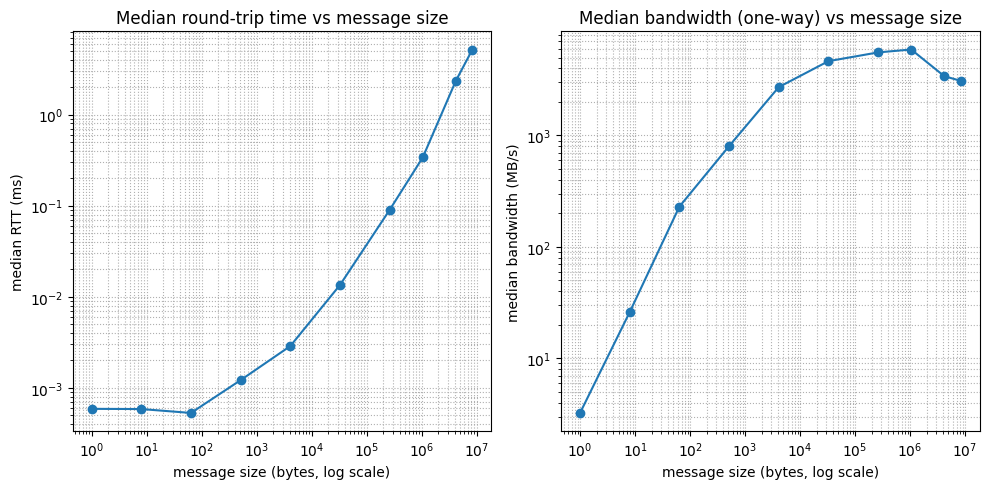

In [4]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
x = groupedFrame["messageSizeBytes"]
y = groupedFrame["medianRTT"] * 1e3  # ms
plt.loglog(x, y, marker='o', linestyle='-')
plt.xlabel("message size (bytes, log scale)")
plt.ylabel("median RTT (ms)")
plt.title("Median round-trip time vs message size")
plt.grid(True, which="both", ls=":")

plt.subplot(1,2,2)
x = groupedFrame["messageSizeBytes"]
y = groupedFrame["medianThroughput"] / (1024.0*1024.0)  # MB/s
plt.loglog(x, y, marker='o', linestyle='-')
plt.xlabel("message size (bytes, log scale)")
plt.ylabel("median bandwidth (MB/s)")
plt.title("Median bandwidth (one-way) vs message size")
plt.grid(True, which="both", ls=":")

plt.tight_layout()
plt.show()


In [5]:
display(groupedFrame.assign(
    medianRTTms = groupedFrame["medianRTT"]*1e3,
    medianThroughputMBs = groupedFrame["medianThroughput"]/(1024*1024)
))


,messageSizeBytes,medianRTT,meanRTT,stdRTT,medianThroughput,meanThroughput,stdThroughput,count,medianRTTms,medianThroughputMBs
0,1,5.890000e-07,7.992000e-07,4.316448e-07,3.396450e+06,2.899263e+06,9.245190e+05,5,0.000589,3.239107
1,8,5.860000e-07,6.140000e-07,4.650269e-08,2.729051e+07,2.616924e+07,1.875198e+06,5,0.000586,26.026260
2,64,5.310000e-07,5.984000e-07,1.048346e-07,2.411398e+08,2.189361e+08,3.614444e+07,5,0.000531,229.968841
3,512,1.217000e-06,1.223400e-06,3.045160e-08,8.411842e+08,8.373219e+08,2.072508e+07,5,0.001217,802.215814
4,4096,2.879000e-06,2.897600e-06,1.797256e-07,2.845684e+09,2.835775e+09,1.682683e+08,5,0.002879,2713.855740
5,32768,1.347000e-05,1.357900e-05,2.667218e-07,4.865477e+09,4.827753e+09,9.238392e+07,5,0.013470,4640.080810
6,262144,8.991600e-05,8.974500e-05,6.611312e-07,5.830872e+09,5.842230e+09,4.324629e+07,5,0.089916,5560.753253
7,1048576,3.387180e-04,3.378532e-04,2.397159e-06,6.191435e+09,6.207538e+09,4.414656e+07,5,0.338718,5904.612113
8,4194304,2.351158e-03,2.253732e-03,2.158063e-04,3.567863e+09,3.753671e+09,4.121947e+08,5,2.351158,3402.579049
9,8388608,5.181842e-03,5.185043e-03,3.345701e-05,3.237693e+09,3.235802e+09,2.086167e+07,5,5.181842,3087.705010
